# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import sklearn.linear_model as sklin
import sklearn.metrics as skmet

In [2]:
from Functions import get_param_names, get_ages_cols

## Directories etc.

In [3]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# Get data

In [4]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)

In [5]:
ages_cols = get_ages_cols()
param_cols = list(set([c for c in all_data.columns for p in get_param_names() if p in c]))
behav_cols = [c for c in all_data.columns if (c not in ages_cols + ['age_group']) and (c not in param_cols)]

## Predict parameters of one task from the others

In [6]:
# predictor_task = 'ps_'
# cols = behav_cols

# dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols + ['age_group']]].dropna()
# X_dat = dat[[c for c in cols if predictor_task in c]]
# y_dat = dat[[c for c in cols if predictor_task not in c]]

# y_col = 'rl_lrn-pinc_sig'

# reg = sklin.Ridge(alpha=100).fit(X_dat, y_dat[y_col])


In [7]:
# np.sum(np.isnan(X_dat))

In [8]:
# np.sum(np.isnan(y_dat[y_col]))

In [9]:
def run_regression_get_r2_coef(X_dat, y_dat, y_col, predictor_task, do_vizualize=False):
    
    # Run regression
#     reg = sklin.LinearRegression().fit(X_dat, y_dat[y_col])
    reg = sklin.Ridge(alpha=100).fit(X_dat, y_dat[y_col])

    # Get coefficients
    coef_row = pd.DataFrame(
        reg.coef_, X_dat.columns
    ).reset_index().rename(
        columns={'index': 'predictor', 0: 'coef'})
    coef_row['outcome'] = y_col
    coef_row['pred_task'] = predictor_task

    # Get R^2
    pred_outcome = reg.predict(X_dat)
    r2 = skmet.r2_score(y_dat[y_col], pred_outcome)
    r2_row = pd.DataFrame({'r2': [r2], 'outcome': [y_col], 'pred_task': [predictor_task]})

    # Vizualize
    if do_vizualize:
        gg.options.figure_size = (3, 3)
        pred_true_dat = pd.DataFrame(np.array([pred_outcome, y_dat[y_col]]).T).rename(columns={0: 'pred', 1: 'true'})
        print(gg.ggplot(pred_true_dat, gg.aes('true', 'pred'))
         + gg.geom_point()
        )

    return r2_row, coef_row

# # Example use
# run_regression_get_r2_coef(X_dat, y_dat, y_col, predictor_task)

In [10]:
def run_all_regression_models(cols, all_data_z):

    # Set up empty DataFrames
    coef_dat = pd.DataFrame()
    r2_dat = pd.DataFrame()

    # Predict 1 task from 1 task
    dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols + ['age_group']]].dropna()
    for predictor_task in ['bf_', 'rl_', 'ps_']:

        # Get predictor and outcome data
        X_dat = dat[[c for c in cols if predictor_task in c]]
        y_dat = dat[[c for c in cols if predictor_task not in c]]

        for y_col in y_dat.columns:
            
            # Run regression
            r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, predictor_task)

            # Concat data
            coef_dat = pd.concat([coef_dat, coef_row])
            r2_dat = pd.concat([r2_dat, r2_row])

    # Predict 1 task from the other 2 tasks
    for outcome_task in ['bf_', 'rl_', 'ps_']:

        # Get predictor and outcome data
        X_dat = dat[[c for c in cols if outcome_task not in c]]
        y_dat = dat[[c for c in cols if outcome_task in c]]

        for y_col in y_dat.columns:

            # Run regression
            r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'both')

            # Concat data
            coef_dat = pd.concat([coef_dat, coef_row])
            r2_dat = pd.concat([r2_dat, r2_row])
            
    return r2_dat, coef_dat

# # Example use
# run_all_regression_models(param_cols, all_data_z)

In [11]:
r2_dat_params, coef_dat_params = run_all_regression_models(param_cols, all_data_z)
r2_dat_behav, coef_dat_behav = run_all_regression_models(behav_cols, all_data_z)

In [12]:
# def run_all_regression_models(cols):

#     # Set up empty DataFrames
#     pred_task_coef = pd.DataFrame()
#     pred_task_r2 = pd.DataFrame()

#     # Predict 1 task from 1 task
#     for predictor_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         pred_param_dat = all_data_z[[c for c in param_cols if predictor_task in c]]
#         out_param_dat = all_data_z[[c for c in param_cols if predictor_task not in c]]

#         for outcome_col in out_param_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(pred_param_dat, out_param_dat, outcome_col, predictor_task)

#             # Concat data
#             pred_task_coef = pd.concat([pred_task_coef, coef_row])
#             pred_task_r2 = pd.concat([pred_task_r2, r2_row])

#     # Predict 1 task from the other 2 tasks
#     for outcome_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         pred_param_dat = all_data_z[[c for c in param_cols if outcome_task not in c]]
#         out_param_dat = all_data_z[[c for c in param_cols if outcome_task in c]]

#         for outcome_col in out_param_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(pred_param_dat, out_param_dat, outcome_col, 'both')

#             # Concat data
#             pred_task_coef = pd.concat([pred_task_coef, coef_row])
#             pred_task_r2 = pd.concat([pred_task_r2, r2_row])
            
#     return pred_task_r2, pred_task_coef

# # Use
# run_all_regression_models(param_cols)

In [13]:
def beautify_coef_r2_df(dat):
    
    dat['out_task'] = dat['outcome'].apply(lambda x : x[:2])
    dat['pred_task'] = pd.Categorical(dat['pred_task'], categories=('both', 'bf_', 'ps_', 'rl_'), ordered=True)
    dat = dat.reset_index(drop=True)
    return dat

# Example use
beautify_coef_r2_df(r2_dat_params)

,r2,outcome,pred_task,out_task
0,0.022895,rl_log_nalpha,bf_,rl
1,0.027036,rl_forget,bf_,rl
2,0.115185,ps_p_reward,bf_,ps
3,0.101384,rl_log_alpha,bf_,rl
4,0.038012,rl_epsilon_1_over_beta,bf_,rl
5,0.026745,rl_K,bf_,rl
6,0.099925,ps_1_over_beta_bf,bf_,ps
7,0.177444,ps_persev_bf,bf_,ps
8,0.022311,ps_alpha,bf_,ps
9,0.136198,ps_persev_rl,bf_,ps


In [14]:
# Beautify DataFrames
coef_dat_params = beautify_coef_r2_df(coef_dat_params)
r2_dat_params = beautify_coef_r2_df(r2_dat_params)

coef_dat_behav = beautify_coef_r2_df(coef_dat_behav)
r2_dat_behav = beautify_coef_r2_df(r2_dat_behav)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\4_PredictParamsByParams_r2.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


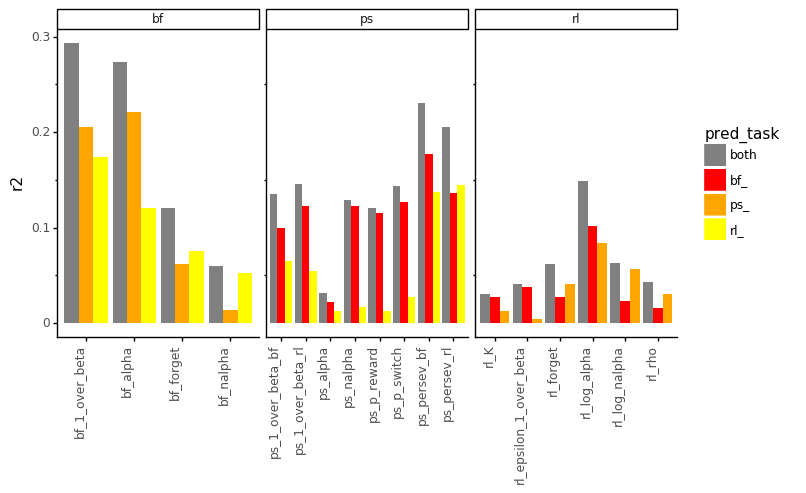

<ggplot: (124631401045)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\4_PredictBehavByBehav_r2.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


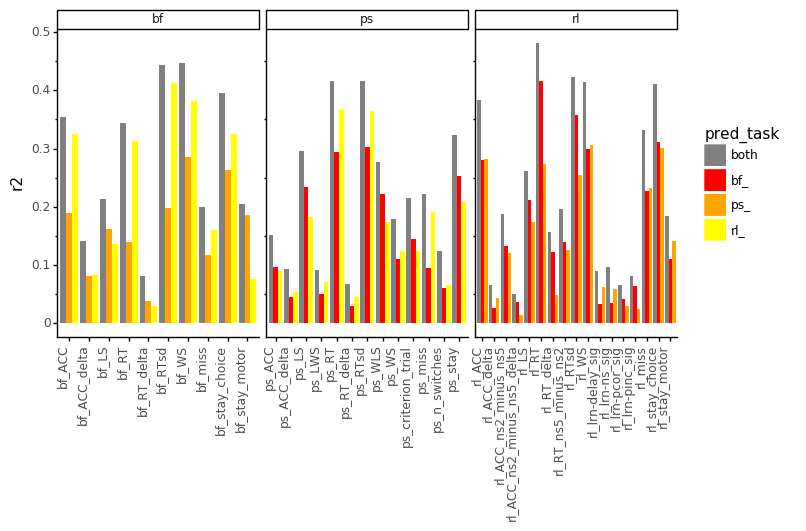

<ggplot: (124632962543)>


In [15]:
def plot_r2(r2_dat, suf):

    gg.options.figure_size = (8, 4)
    g = (gg.ggplot(r2_dat, gg.aes('outcome', 'r2', fill='pred_task'))
         + gg.geom_bar(stat='identity', position=gg.position_dodge(width=0.9))
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=1))
         + gg.scale_fill_manual(values=('grey', 'red', 'orange', 'yellow'))
         + gg.labs(x='')
         + gg.facet_wrap('~ out_task', scales='free_x')
        )

    g.save(os.path.join(plot_save_path, '4_Predict{0}By{0}_r2.png'.format(suf)))
    return g

# Use
print(plot_r2(r2_dat_params, 'Params'))
print(plot_r2(r2_dat_behav, 'Behav'))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 70 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\4_PredictParamsByParams_coef_onlyboth.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


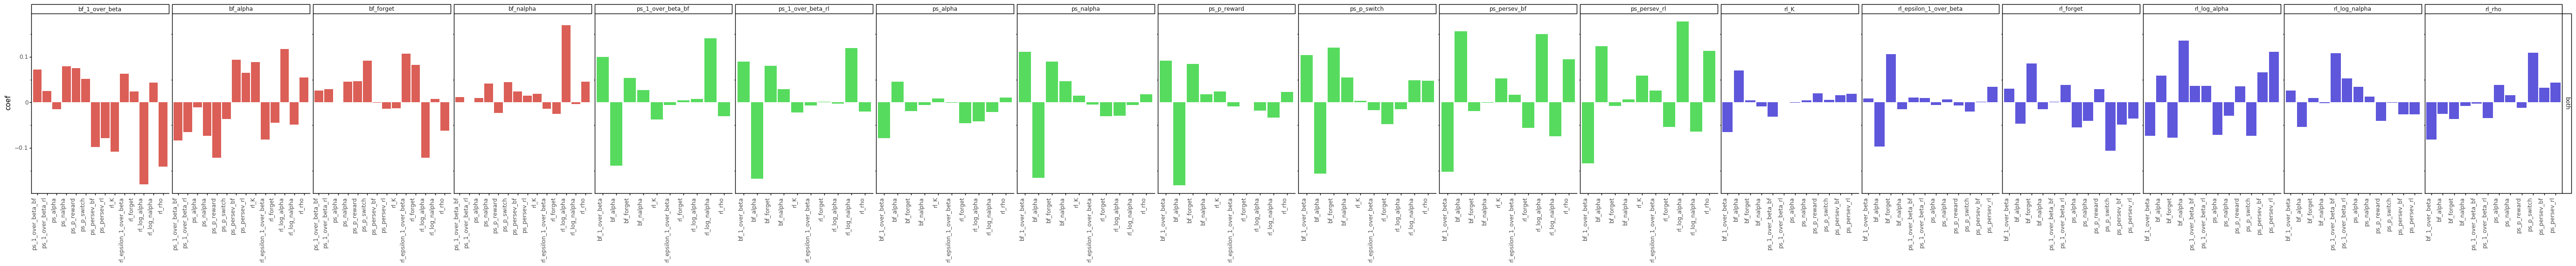

<ggplot: (124632987414)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 70 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\4_PredictBehavByBehav_coef_onlyboth.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


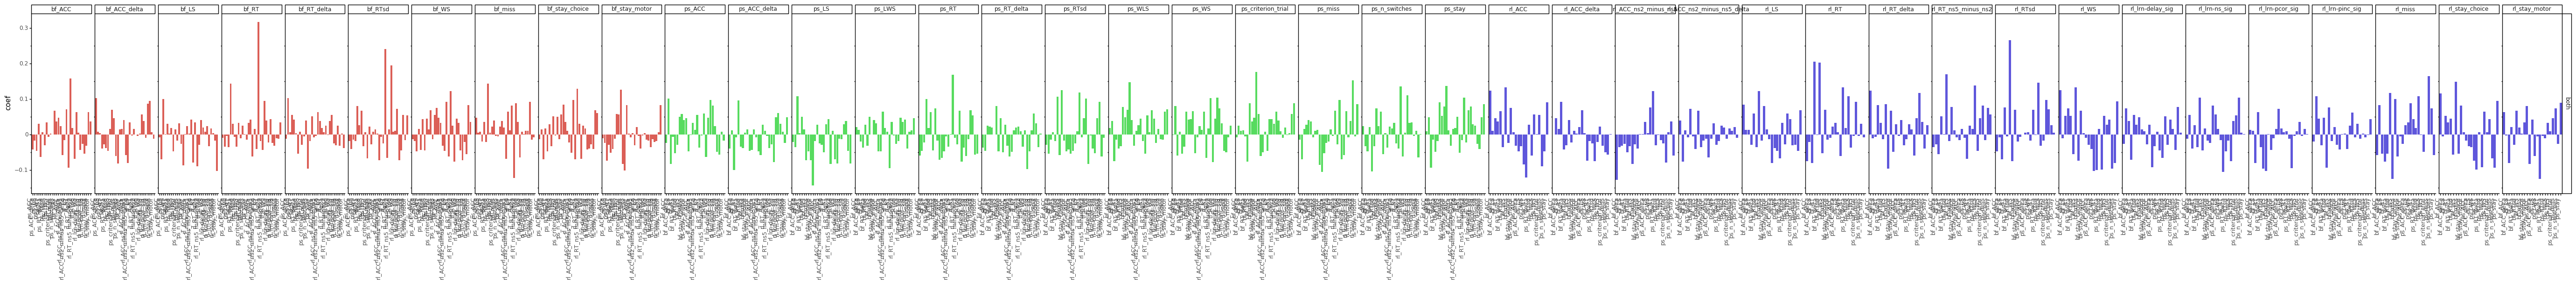

<ggplot: (-9223371912221758660)>


In [16]:
def plot_coef(coef_dat, suf):

    # Subset model with both tasks only (individual tasks are very similar)
    sub = coef_dat.loc[coef_dat['pred_task'] == 'both']

    gg.options.figure_size = (70, 5)
    g = (gg.ggplot(sub, gg.aes('predictor', 'coef', fill='out_task'))
         + gg.geom_bar(stat='identity')
         + gg.labs(x='')
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=1))
         + gg.theme(legend_position='none')
    #      + gg.facet_wrap('~ pred_task + outcome', scales='free_x', labeller='label_context')
         + gg.facet_grid('pred_task ~ outcome', scales='free_x')
        )

    g.save(os.path.join(plot_save_path, '4_Predict{0}By{0}_coef_onlyboth.png'.format(suf)), limitsize=False)
    return g

# Use
print(plot_coef(coef_dat_params, 'Params'))
print(plot_coef(coef_dat_behav, 'Behav'))